In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.cluster import KMeans
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
from datetime import datetime, timedelta

In [11]:
import plotly.offline as py 
import plotly.graph_objs as go 
from IPython.display import IFrame

In [557]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)

data1 = data[data.iloc[:,-1] == 1]
data0 = data[data.iloc[:,-1] == 0]

data1 = data1[['机组有功负荷','定子线棒温度']].values
data0 = data0[['机组有功负荷','定子线棒温度']].values

Text(0, 0.5, '定子线圈温度')

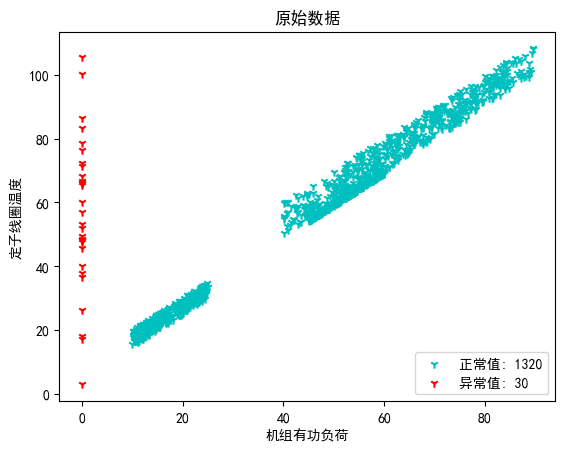

In [558]:
plt.scatter(x=data0[:, 0], y=data0[:, 1], c='c', marker='1', )
plt.scatter(x=data1[:, 0], y=data1[:, 1], c='r', marker='1', )
plt.legend([f"正常值: {len(data0)}", f"异常值: {len(data1)}"])
plt.title("原始数据")
plt.xlabel("机组有功负荷")
plt.ylabel("定子线圈温度")

In [559]:
data['标签'].value_counts()

0    1320
1      30
Name: 标签, dtype: int64

In [587]:
# 设置起始时间
start_time = datetime.strptime("01:20:45", '%H:%M:%S')

# 生成时间点，仅提取时分秒
num_time_points = 1350
time_points = [(start_time + timedelta(minutes=i)).strftime('%H:%M:%S') for i in range(num_time_points)]

data.insert(0, '时间', time_points)

data['时间'] = pd.to_datetime(data['时间'])
data = data.set_index("时间")

data.columns = ['机组有功负荷', '定子线圈温度', '标签']

In [588]:
py.init_notebook_mode(connected=True)

column_values = data.columns[:-1].values 
time_column =data.index
trace_list = []
colors =['mediumslateblue', 'salmon']

for i in range(len(column_values)):
    data_column = data[column_values[i]]
    trace = go.Scatter(x=time_column, y=data_column, mode='lines', name=column_values[i], line=dict(color=colors[i]))
    trace_list.append(trace)

layout= go.Layout(title='模拟数据', xaxis={'tickangle':60}, yaxis={"title":"Values"}, )

fig = go.Figure(trace_list, layout)  
fig.show()

# 数据分析

In [562]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)
data

,机组有功负荷,定子线棒温度,标签
0,14.85,24.39,0
1,11.24,16.86,0
2,13.42,18.70,0
3,15.43,24.06,0
4,22.70,30.79,0
...,...,...,...
1345,42.90,57.11,0
1346,55.53,71.81,0
1347,57.29,74.61,0
1348,62.66,79.44,0


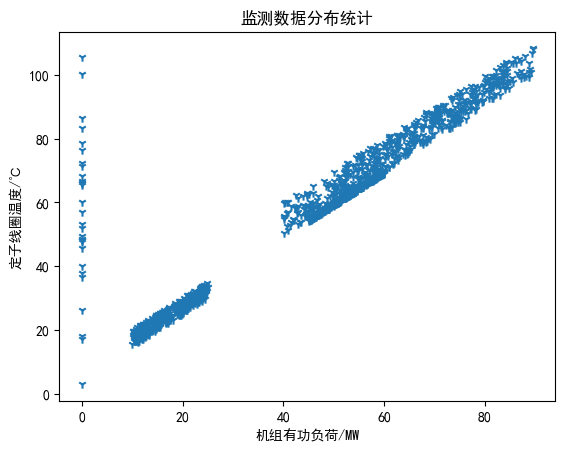

In [563]:
plt.scatter(x=data.iloc[:, 0], y=data.iloc[:, 1], marker='1')
plt.title("监测数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.show()

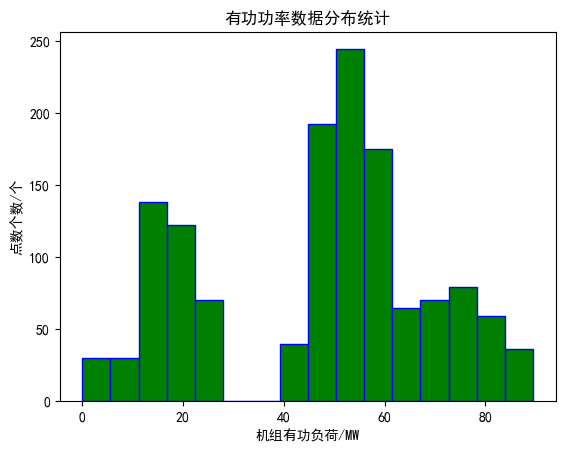

In [593]:
plt.hist(data.iloc[:,0], bins=16, edgecolor="b", color='green')
plt.title("有功功率数据分布统计")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("点数个数/个")
plt.show()

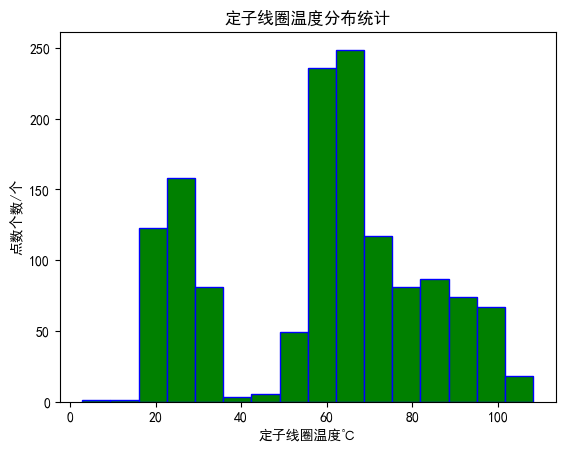

In [594]:
plt.hist(data.iloc[:,1], bins=16, edgecolor="b", color='green')
plt.title("定子线圈温度分布统计")
plt.xlabel("定子线圈温度℃")
plt.ylabel("点数个数/个")
plt.show()

# 异常检测

## KNN

In [566]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)

X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1]

In [567]:
# 训练一个kNN检测器
clf_name = 'kNN'
clf = KNN(contamination=0.03) 
clf.fit(X_train) 

y_train_scores = clf.decision_scores_  
y_train_pred = clf.predict(X_train)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)

X_train['pred_label'] = y_train_pred

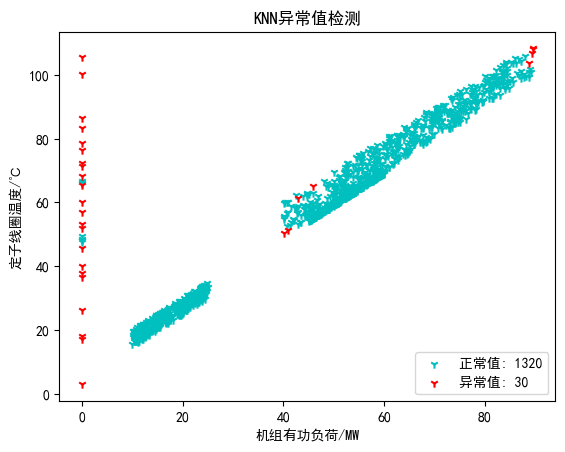

In [568]:
id_data = X_train[X_train.iloc[:,-1] == 0].values
od_data = X_train[X_train.iloc[:,-1] == 1].values

plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend([f"正常值: {len(id_data)}", f"异常值: {len(od_data)}"]) 
plt.title("KNN异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
# plt.savefig("../image/KNN异常值检测.png", dpi=600)
plt.show()

## IsolationForest

In [569]:
import warnings
warnings.filterwarnings('ignore')

from pyod.utils.data import evaluate_print
# from pyod.utils.example import visualize
from sklearn.model_selection import GridSearchCV

In [570]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)
X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1]

In [571]:
# 训练一个kNN检测器
clf = IForest(contamination=0.03) 
clf.fit(X_train) 

y_train_scores = clf.decision_scores_  
y_train_pred = clf.predict(X_train)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)

X_train['pred_label'] = y_train_pred

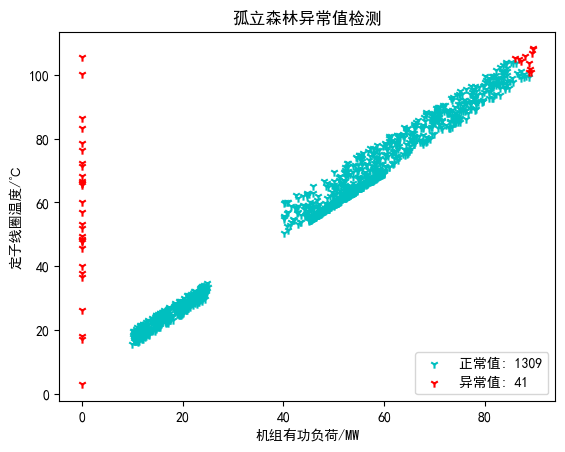

In [572]:
id_data = X_train[X_train.iloc[:,-1] == 0].values
od_data = X_train[X_train.iloc[:,-1] == 1].values

plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend([f"正常值: {len(id_data)}", f"异常值: {len(od_data)}"]) 
plt.title("孤立森林异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.show()

## LOF

In [573]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)
X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1]

In [574]:
# 训练一个LOF检测器
clf = LOF(contamination=0.03) 
clf.fit(X_train) 

y_train_scores = clf.decision_scores_  
y_train_pred = clf.predict(X_train)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)

X_train['pred_label'] = y_train_pred

In [575]:
X_train['pred_label'].value_counts()

0    1315
1      35
Name: pred_label, dtype: int64

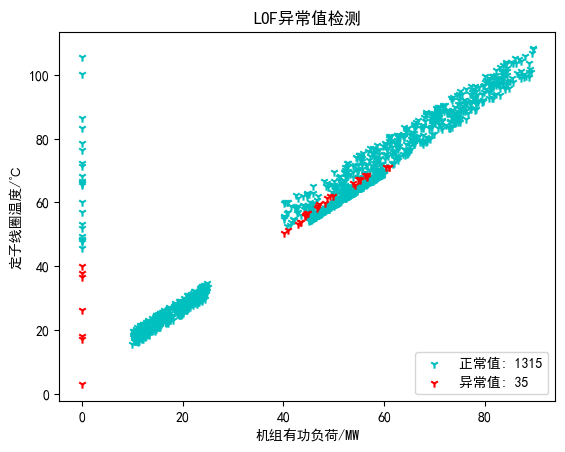

In [576]:
id_data = X_train[X_train.iloc[:,-1] == 0].values
od_data = X_train[X_train.iloc[:,-1] == 1].values

plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend([f"正常值: {len(id_data)}", f"异常值: {len(od_data)}"]) 

plt.title("LOF异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.show()

## OCSVM

In [577]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)
X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1]

In [578]:
# 训练一个OCSVM检测器
clf = OCSVM(contamination=0.03)
clf.fit(X_train) 

y_train_scores = clf.decision_scores_  
y_train_pred = clf.predict(X_train)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)

X_train['pred_label'] = y_train_pred

In [579]:
X_train['pred_label'].value_counts()

0    1309
1      41
Name: pred_label, dtype: int64

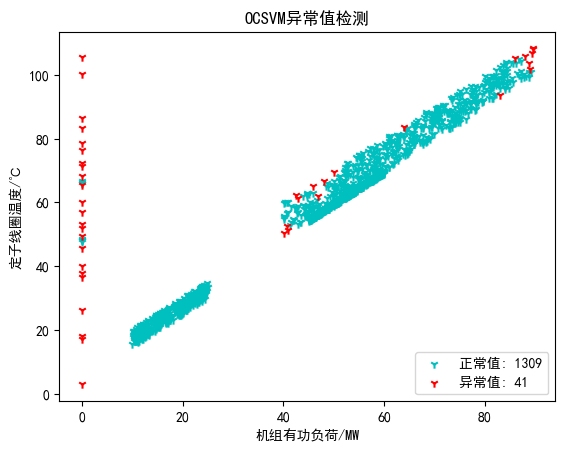

In [580]:
id_data = X_train[X_train.iloc[:,-1] == 0].values
od_data = X_train[X_train.iloc[:,-1] == 1].values

plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend([f"正常值: {len(id_data)}", f"异常值: {len(od_data)}"]) 

plt.title("OCSVM异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
# plt.savefig("../image/OCSVM异常值检测.png", dpi=600)
plt.show()

## MCD

In [622]:
from pyod.models.mcd import MCD

In [634]:
data = pd.read_csv("npno.csv", index_col=0).reset_index(drop=True)
X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1]

In [635]:
clf = MCD(contamination=0.03)

clf.fit(X_train) 

y_train_scores = clf.decision_scores_  
y_train_pred = clf.predict(X_train)  # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)

X_train['pred_label'] = y_train_pred

In [636]:
X_train['pred_label'].value_counts()

0    1309
1      41
Name: pred_label, dtype: int64

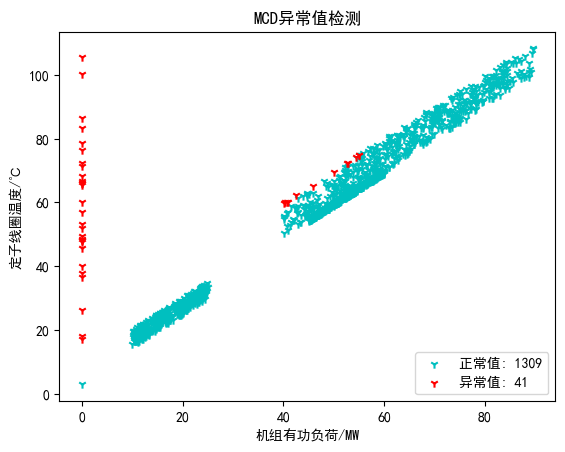

In [637]:
id_data = X_train[X_train.iloc[:,-1] == 0].values
od_data = X_train[X_train.iloc[:,-1] == 1].values

plt.scatter(x=id_data[:, 0], y=id_data[:, 1], c='c', marker='1', )
plt.scatter(x=od_data[:, 0], y=od_data[:, 1], c='r', marker='1', )
plt.legend([f"正常值: {len(id_data)}", f"异常值: {len(od_data)}"]) 

plt.title("MCD异常值检测")
plt.xlabel("机组有功负荷/MW")
plt.ylabel("定子线圈温度/℃")
plt.show()